<h1 style="background-color:#6d8f54;font-family:Open Sans Light;font-size:250%;text-align:center;border-radius: 10px 10px;">Home Credit Default Risk Project</h1>


<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/about-us-home-credit.jpg"></img>


# <a style="background-color:white;font-family:Open Sans Light;font-size:150%;text-align:center;border-radius: 10px 10px;" id=1 > Introduction</a>

Home Credit s'efforce d'élargir l'inclusion financière de la population non bancarisée en offrant une expérience d'emprunt positive et sûre. Afin de s'assurer que cette population mal desservie a une expérience de prêt positive, Home Credit utilise une variété de données alternatives pour prédire les capacités de remboursement de ses clients.

# <a style="background-color:white;font-family:Open Sans Light;font-size:150%;text-align:center;border-radius: 10px 10px;" id=1 > Les Données </a>

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service destiné à fournir des lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt est un besoin commercial important pour Home Credit

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>


Comme on peut le voir sur cette figure, Il y a 7 sources de données différentes :

**application_train/application_test** : les principales données (train et test) contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la variable `SK_ID_CURR`. Les données de demande d'entraînement sont accompagnées de la caractéristique `TARGET` indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. 
* **bureau** : données concernant les prêts précédents du client auprès d'autres institutions financières. Chaque prêt précédent a sa propre ligne dans le bureau, mais un prêt dans les données de la base application peut avoir plusieurs prêts précédents.
* **bureau_balance:** données mensuelles concernant les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit. 
* **previous_application** : demandes précédentes de prêts au Home Credit des clients qui ont des prêts dans les données de application. Chaque prêt actuel dans les données de application peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE:** données mensuelles sur les précédents prêts au point de vente ou au comptant que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de prêt au point de vente ou au comptant, et un seul prêt peut avoir plusieurs lignes.
* **credit_card_balance:** données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne représente un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installations_payment:** historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué. 

# <a id="1">1. Import Statements</a> 

In [9]:
#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns # for making plots with seaborn
import warnings
warnings.filterwarnings('ignore')


C:\Users\lenovo\AppData\Python\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [8]:
import warnings
warnings.filterwarnings('ignore')

## OBJECTIFS DE CETTE ANALYSE

Analyser les données base par base pour voir dans quelle mesure il serait interresant de fusionner les bases ensembles pour avoir l'ensemble des informations dans une seule base de données

### Fonctions pour faire des graphiques

In [4]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Fonctions pour faire des distributions

In [5]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

# <a id="2">2. Chargement des données train et set </a>

In [11]:
#Train Dataset
train = pd.read_csv('C:/Users/lenovo/application_train.csv')
print(train.shape)

(307511, 122)


In [7]:
train.groupby('SK_ID_CURR').head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

### Analyse des données du train set

#### Types de contracts

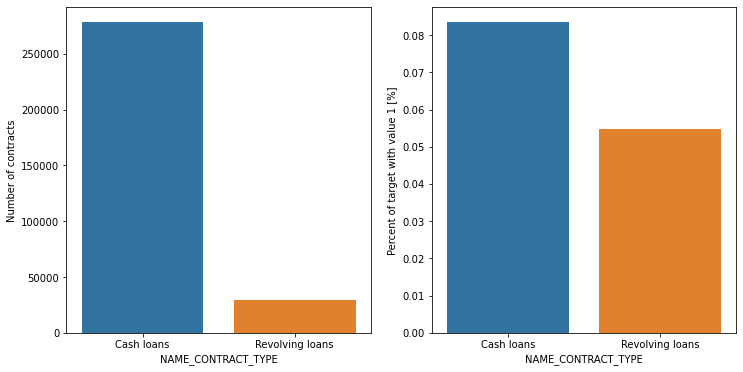

In [12]:
plot_stats('NAME_CONTRACT_TYPE')

Les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts ; dans le même temps, un plus grand nombre de prêts renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

### Sexe du client

Voyons le sexe des clients et aussi, sur un graphique séparé, le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non remboursé).

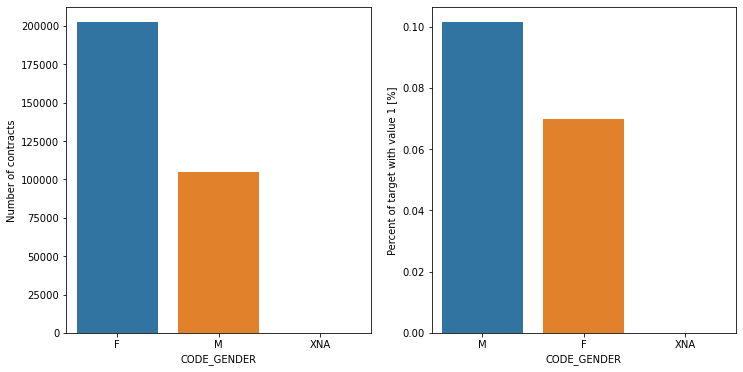

In [13]:
plot_stats('CODE_GENDER')

Le nombre de clients féminins est presque le double du nombre de clients masculins. Si l'on considère le pourcentage de crédits non remboursés, les hommes ont plus de chances de ne pas rembourser leurs prêts (environ 10%), par rapport aux femmes (environ 7%).

### Drapeau "voiture" et drapeau "biens immobiliers".

Examinons les drapeaux qui nous indiquent si un client possède une voiture ou un bien immobilier et, sur des graphiques séparés, le pourcentage de la valeur des prêts de ces drapeaux) avec la valeur TARGET 1 (prêt non remboursé).

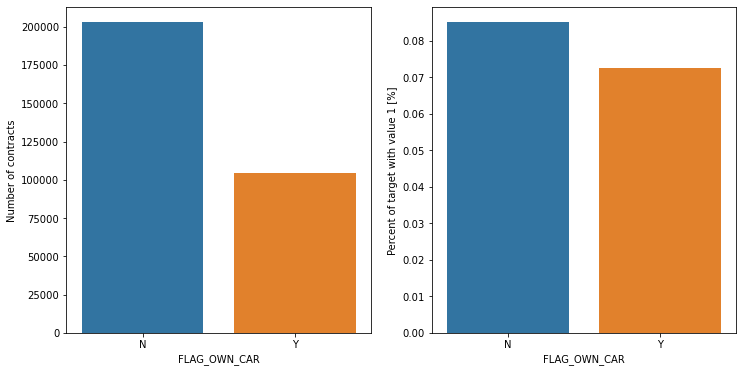

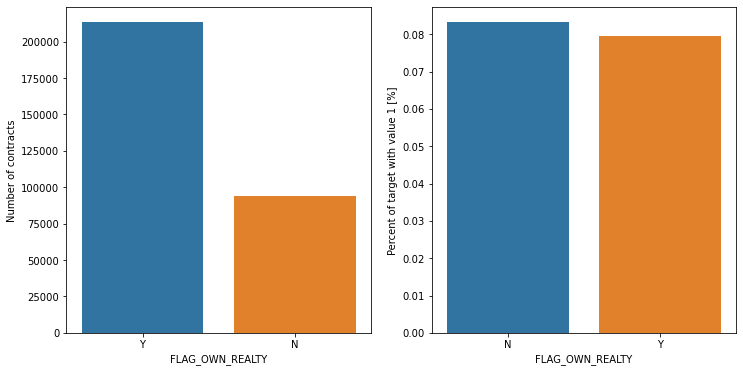

In [14]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

Les clients qui possèdent une voiture représentent presque la moitié de ceux qui n'en possèdent pas. Les clients qui possèdent une voiture sont moins susceptibles de ne pas rembourser une voiture que ceux qui n'en possèdent pas. Les deux catégories ont un taux de non-remboursement d'environ 8%.

Les clients qui possèdent un bien immobilier sont plus de deux fois plus nombreux que ceux qui n'en possèdent pas. Les deux catégories (propriétaire ou non propriétaire) ont un taux de non-remboursement inférieur à 8%.


### Situation familiale du client

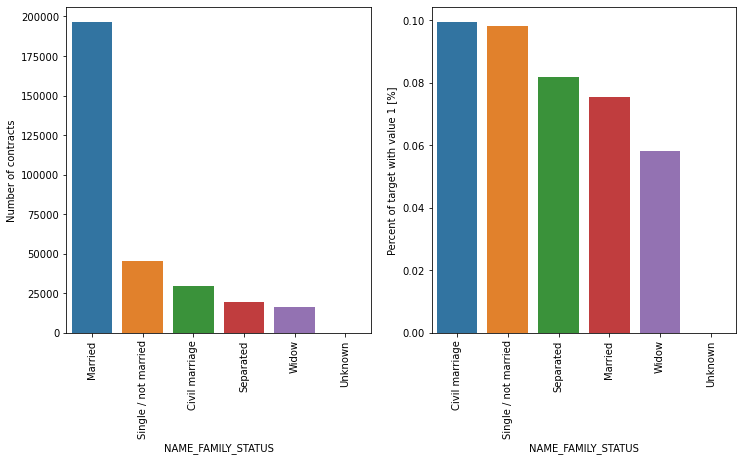

In [15]:
plot_stats('NAME_FAMILY_STATUS',True, True)

La plupart des clients sont mariés, suivis par les célibataires/non mariés et les mariages civils.

En termes de pourcentage de non-remboursement du prêt, le mariage civil présente le pourcentage le plus élevé de non-remboursement (10%), et le veuvage le plus faible (l'exception étant *Inconnu*).

### Nombre d'enfants

Voyons quelle est la distribution du nombre d'enfants des clients.

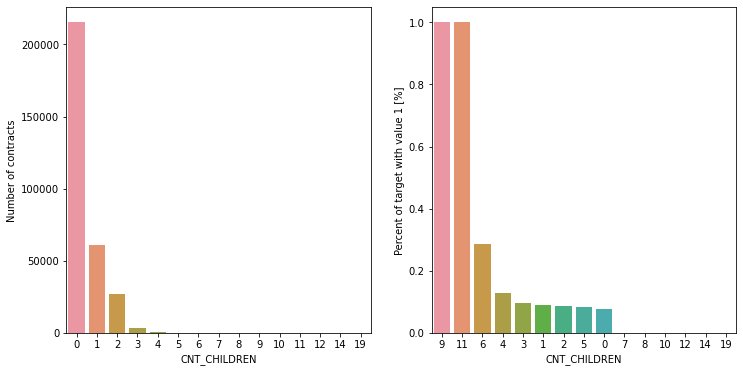

In [16]:
plot_stats('CNT_CHILDREN')

La plupart des clients qui contractent un prêt n'ont pas d'enfants. Le nombre de prêts associés aux clients ayant un enfant est 4 fois plus faible, le nombre de prêts associés aux clients ayant deux enfants est 8 fois plus faible ; les clients ayant 3, 4 enfants ou plus sont beaucoup plus rares. 

Quant au remboursement, les clients sans enfant, avec 1, 2, 3 et 5 enfants ont des pourcentages de non-remboursement autour de la moyenne (10%). Les clients avec 4 et 6 enfants sont au-dessus de la moyenne en termes de pourcentage de prêts non remboursés (plus de 25% pour les familles avec 6 enfants).

Quant aux clients avec 9 ou 11 enfants, le pourcentage de prêts non remboursés est de 100%.

### Nombre de membres de la famille du client

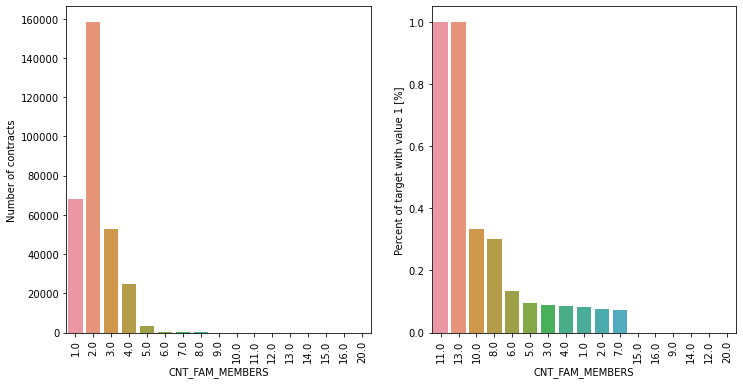

In [17]:
plot_stats('CNT_FAM_MEMBERS',True)

Les clients dont la famille compte 2 membres sont les plus nombreux, suivis de 1 (personnes seules), 3 (familles avec un enfant) et 4.

Les clients dont la famille compte 11 et 13 membres ont un taux de non-remboursement de 100%. D'autres familles de 10 ou 8 membres ont des pourcentages de non-remboursement des prêts supérieurs à 30%. Les familles de 6 membres ou moins ont des taux de remboursement proches de la moyenne de 10%.

### Type de revenu du client

Examinons le nombre de clients avec différents types de revenus. De même, voyons le pourcentage de prêts non remboursés par type de revenu des demandeurs.

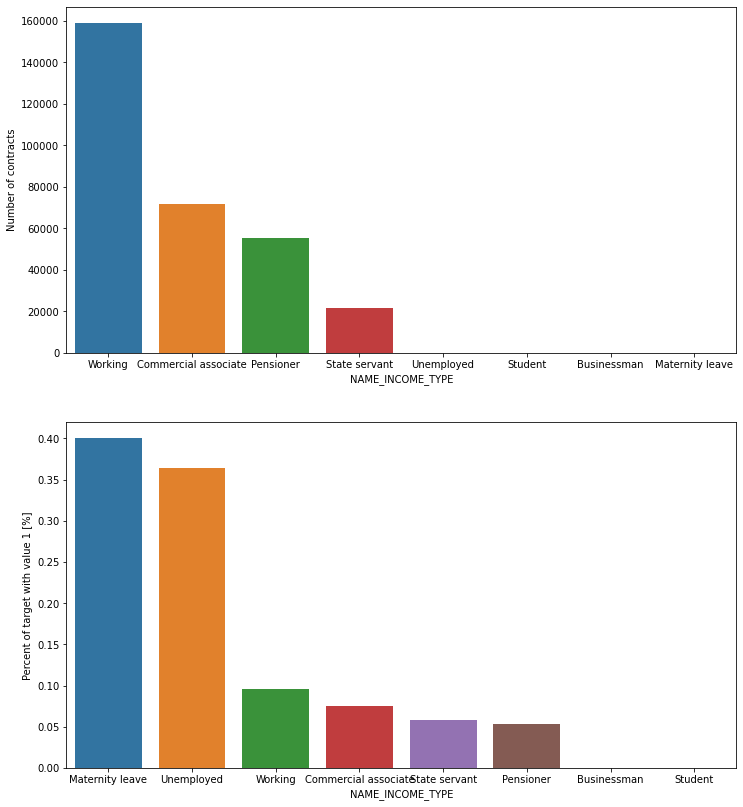

In [18]:
plot_stats('NAME_INCOME_TYPE',False,False)

La plupart des demandeurs de prêts ont un revenu provenant d'un *travailleur*, suivi d'un *associé commercial*, d'un *pensionné* et d'un *fonctionnaire de l'État*.

Les demandeurs avec le type de revenu *Congé maternité* ont un taux de non remboursement de près de 40%, suivi par les *Chômeurs* (37%). Les autres types de revenus se situent en dessous de la moyenne de 10% de non remboursement des prêts.


### Ocupation du client

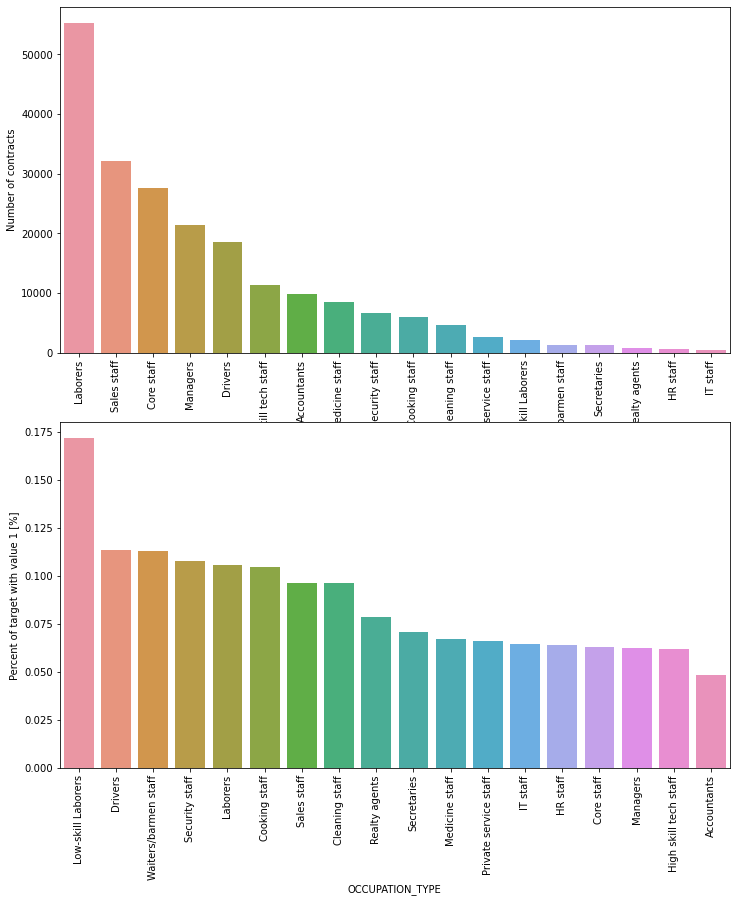

In [19]:
plot_stats('OCCUPATION_TYPE',True, False)

La plupart des prêts sont contractés par les *ouvriers*, suivis par le *personnel de vente*. *Le personnel informatique est celui qui emprunte le moins.

La catégorie présentant le pourcentage le plus élevé de prêts non remboursés est celle des *Ouvriers peu qualifiés* (plus de 17%), suivie par les *Conducteurs* et les *Serveurs/barmans*, les *Assistants de sécurité*, les *Euvres* et les *Cuisiniers*.

### Type d'Organisation 

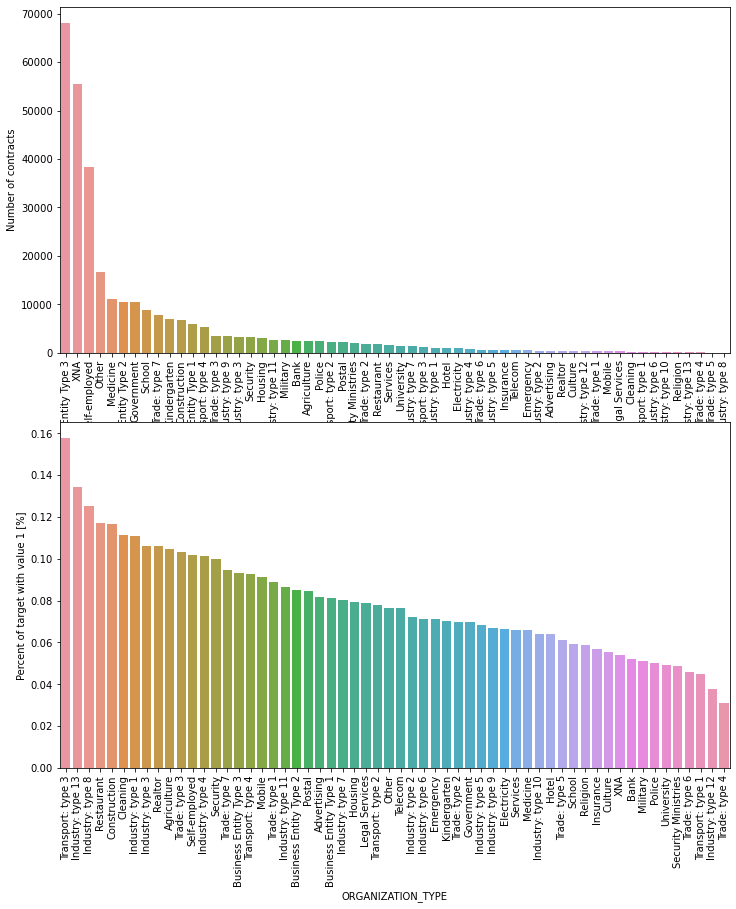

In [20]:
plot_stats('ORGANIZATION_TYPE',True, False)

Les organisations ayant le pourcentage le plus élevé de prêts non remboursés sont *Transport : type 3* (16%), *Industrie : type 13* (13,5%), *Industrie : type 8* (12,5%) et *Restaurant* (moins de 12%).

### Type d'éducation du client

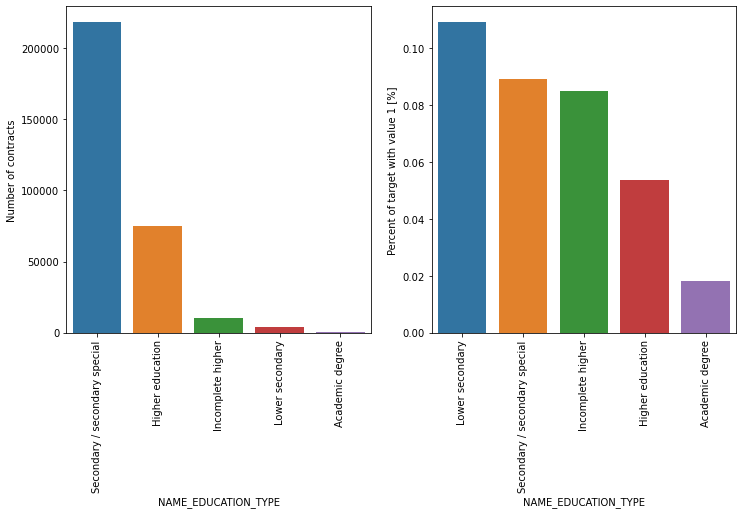

In [21]:
plot_stats('NAME_EDUCATION_TYPE',True)

La majorité des clients ont une éducation secondaire / secondaire spécialisée, suivie par les clients ayant une éducation supérieure. Seul un très petit nombre d'entre eux ont un diplôme universitaire.

La catégorie du secondaire inférieur, bien que rare, présente le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme académique ont un taux de non-remboursement inférieur à 2%.

### Chargement du test set application

In [12]:
#Test Dataset
test = pd.read_csv('C:/Users/lenovo/application_test.csv')
print(test.shape)
#test.head()

(48744, 121)


In [9]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Chargement et analyse des informations au niveau du bureau du credit

In [13]:
bureau = pd.read_csv('C:/Users/lenovo/bureau.csv')

In [23]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


###### Pour analyser des données de bureau, il faut necessairement des données de train_application qui contient le target. Il faut les fusionner

In [14]:
bureau_train =train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [63]:
bureau_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-1038.0,NaN,0,40761.0,NaN,NaN,0.0,Credit card,-1038,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-48.0,NaN,0,0.0,0.00,NaN,0.0,Credit card,-47,NaN
2,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-1185.0,0.000,0,135000.0,0.00,0.0,0.0,Consumer credit,-1185,0.0
3,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-911.0,3321.000,0,19071.0,NaN,NaN,0.0,Consumer credit,-906,0.0
4,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-36.0,5043.645,0,120735.0,0.00,0.0,0.0,Consumer credit,-34,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465320,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,NaN,0.000,0,436032.0,363573.54,0.0,0.0,Consumer credit,-25,0.0
1465321,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,NaN,15439.905,0,450000.0,191005.47,0.0,0.0,Consumer credit,-55,3244.5
1465322,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,-781.0,25578.000,0,900000.0,NaN,NaN,0.0,Consumer credit,-781,0.0
1465323,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,-779.0,2646.000,1,38925.0,NaN,NaN,0.0,Credit card,-779,3244.5


In [32]:
print("Les données résultant de la fusion de `bureau et train_application` a ",bureau_train.shape[0]," lignes et ", 
      bureau_train.shape[1]," colonnes.")

Les données résultant de la fusion de `bureau et train_application` a  1465325  lignes et  138  colonnes.


#### Analysons maintenant les données bureau_train.

In [28]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Statut de crédit

Voyons la distribution du statut de crédit. Nous montrons d'abord le nombre de crédits par catégorie (pouvant être *Fermé*, *Actif*, *Vendu* et *Mauvaise dette*).

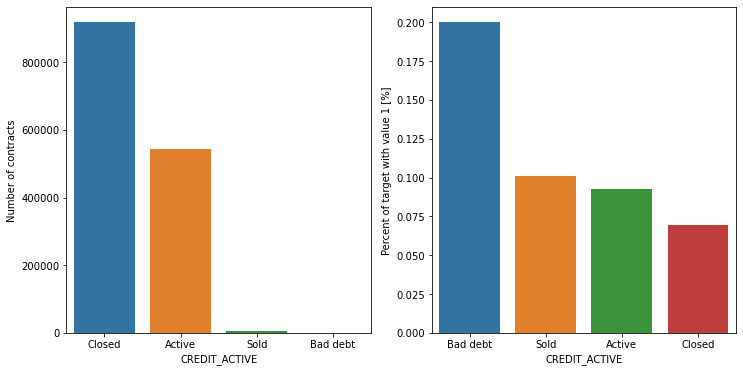

In [29]:
plot_b_stats('CREDIT_ACTIVE')

La plupart des crédits enregistrés au Credit Bureau sont dans le statut *Closed* (~900K). En deuxième position, on trouve les crédits *Actifs* (un peu moins de 600 000). Les crédits *Vendus* et *Mauvaise dette* ne sont que quelques exemples.

Dans le même temps, en pourcentage ayant **TARGET = 1** par rapport au nombre total par catégorie, les clients ayant des crédits enregistrés au Bureau de crédit avec *Mauvaise dette* ont 20% de défaut sur les demandes en cours. 


Les clients avec des crédits *Vendus*, *Actifs* et *Fermés* ont un pourcentage de **TARGET == 1** (crédit par défaut) égal ou inférieur à 10% (10% étant le taux global). Les clients dont les crédits sont enregistrés au Credit Bureau avec des crédits *Closed* ont le plus faible taux de crédit par défaut.

Cela signifie que l'ancien historique de crédit enregistré (tel qu'enregistré au Credit Bureau) est un prédicteur fort pour le crédit par défaut, puisque le pourcentage de demandes en défaut avec un historique de *Mauvaise dette* est deux fois plus important que pour *Vendu* ou *Actif* et presque trois fois plus important que pour *Fermé*.

### Type de crédit

Vérifions maintenant les types de crédit pour les crédits enregistrés auprès du Bureau de crédit.

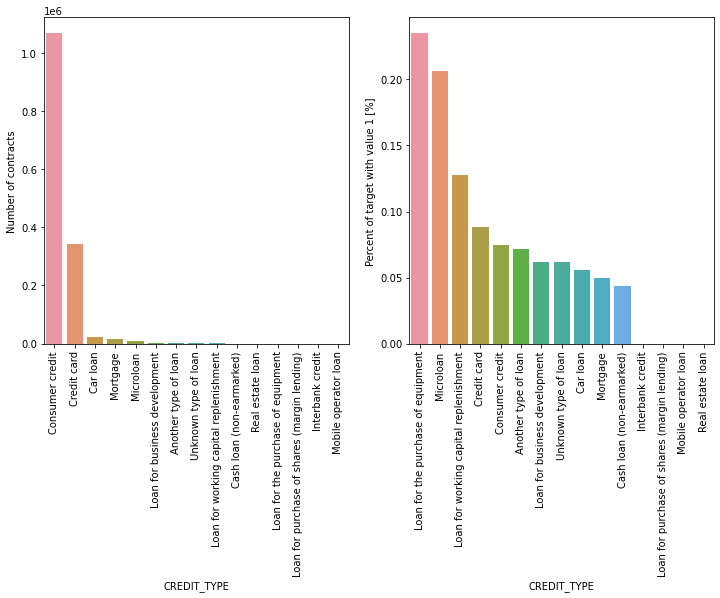

In [33]:
plot_b_stats('CREDIT_TYPE', True, True)

La majorité des crédits historiques enregistrés au Bureau de crédit sont des *crédits à la consommation* et des *cartes de crédit*. Un plus petit nombre de crédits sont *Prêt automobile*, *Hypothèque* et *Microcrédit*.

Si l'on considère maintenant les types de crédits historiques enregistrés auprès du Credit Bureau, on constate que certains types présentent un pourcentage élevé de défauts de paiement actuels, à savoir  
*Prêt pour l'achat d'équipement* - avec plus de 20% de défauts de paiement actuels ;  
*Microloan* - avec plus de 20% de défauts de paiement ;  
*Prêt pour le réapprovisionnement du fonds de roulement* - avec plus de 12% de défauts de paiement. 

### Durée du crédit (DAYS_CREDIT)

Vérifions la distribution du nombre de jours pour le crédit (enregistré au bureau de crédit).


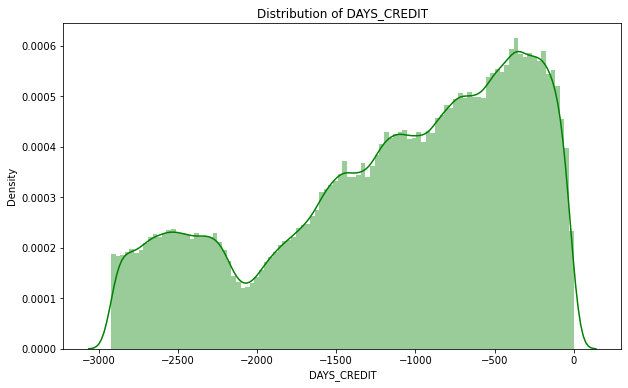

In [35]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

<a href="#0"><font size="1">Go to top</font></a>

## <a id="43">Données sur les demandes précédentes de prêts </a>


La base de données *previous_application* contient des informations sur toutes les demandes antérieures de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données. **SK_ID_CURR** est la clé qui relie les données *application_train*|*test* aux données *previous_application*.

Fusionnons *application_train* avec *previous_application*.

In [15]:
previous_application = pd.read_csv('C:/Users/lenovo/previous_application.csv')

In [16]:
application_prev_train = train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [40]:
print("Les données resultant de la fusion de `train et previous_application` ont ",application_prev_train.shape[0]," lignes et", 
      application_prev_train.shape[1]," colonnes.")

Les données resultant de la fusion de `train et previous_application` ont  1413701  lignes et 158  colonnes.


### Fonctions d'analyse

In [17]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

<a href="#0"><font size="1">remonter</font></a>


## <a id="44">Type de contrats</a>

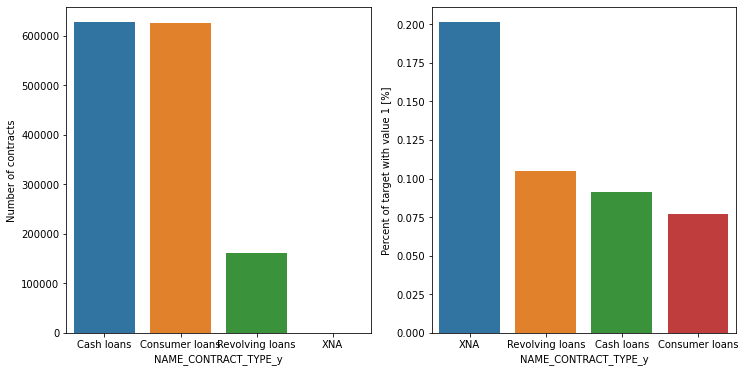

In [42]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

Il existe trois types de contrats dans les données de l'application précédente : *Cash loans*, *Consumer loans*, *Revolving loans*. Les *prêts en espèces* et les *prêts à la consommation* sont presque au même niveau (~600K) tandis que les *prêts renouvelables* sont ~150K.

Le pourcentage de prêts non remboursés pour les clients ayant déjà fait une demande est différent selon le type de contrats de demandes précédentes, diminuant de ~10% pour les *prêts renouvelables*, puis de ~9,5% pour les *prêts à la consommation* et de ~8% pour les *prêts à la consommation*.

### Objectif du prêt d'argent

Examinons l'objectif du prêt en espèces, dans le cas des prêts en espèces.

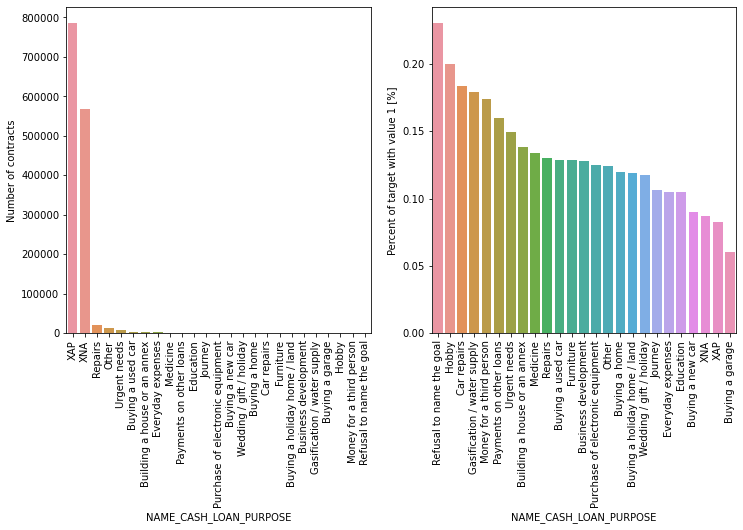

In [43]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Outre les catégories non identifiées/non disponibles, les catégories *Réparations*, *Autres*, *Besoins urgents*, *Achat d'une voiture d'occasion*, *Construction d'une maison ou d'une annexe* représentent le plus grand nombre de contrats.


En termes de pourcentage de défaillances pour les demandes actuelles de l'échantillon, les clients ayant des antécédents de demandes antérieures ont les pourcentages de défaillances les plus élevés lorsque dans leur historique figurent des demandes antérieures de prêts d'argent pour Refus de nommer l'objectif - environ 23% (ce qui est très logique), Hobby (environ 20%), Réparation de voiture (environ 18%).

### Statut du contrat

Regardons le statut du contrat.

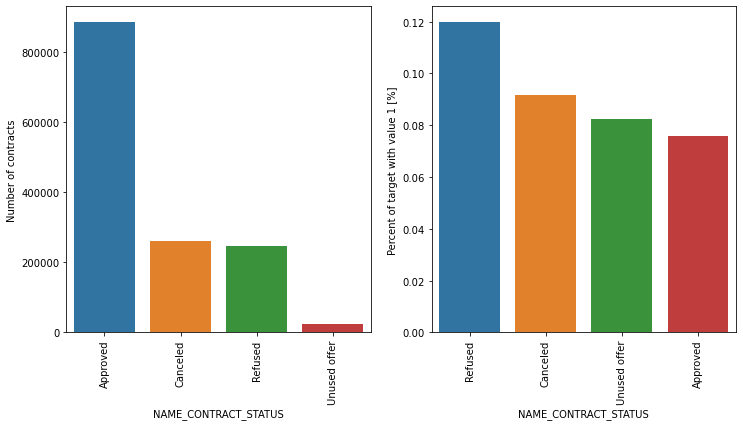

In [44]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

La plupart des statuts contractuels des demandes précédentes sont *Approuvé* (environ 850K), *Annulé* et *Refusé* (environ 240K). Il n'y a que ~20K dans le statut *Offre non utilisée*.

En termes de pourcentage de défauts pour les demandes actuelles de l'échantillon, les clients ayant des antécédents de demandes antérieures présentent les pourcentages de défauts les plus élevés lorsque les statuts de contrat dans leur historique sont *Refusé* (12%), suivis par *Annulé* (9%), *Offre non utilisée* (environ 8%) et *Approuvé* (pourcentage le plus faible de défauts dans les demandes actuelles, avec moins de 8%).

### Type de paiement

Vérifions le type de paiement.

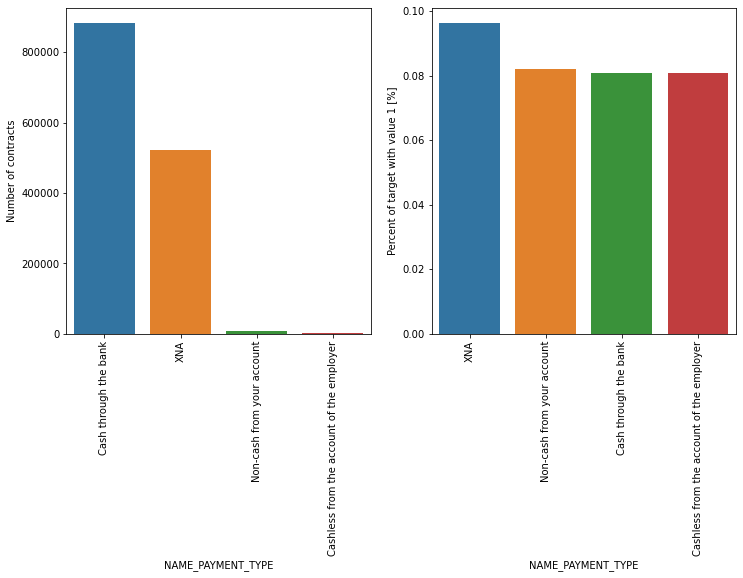

In [46]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

La plupart des demandes précédentes ont été payées avec *des espèces par la banque* (environ 850K). Les paiements par *Non-cash de votre compte* ou *Cashless du compte de l'employeur* sont beaucoup plus rares. Ces trois types de paiements dans les demandes antérieures entraînent pratiquement le même pourcentage de défauts pour les clients actuels (environ 8% chacun).

### Type de client

Vérifions le type de client pour les applications précédentes.

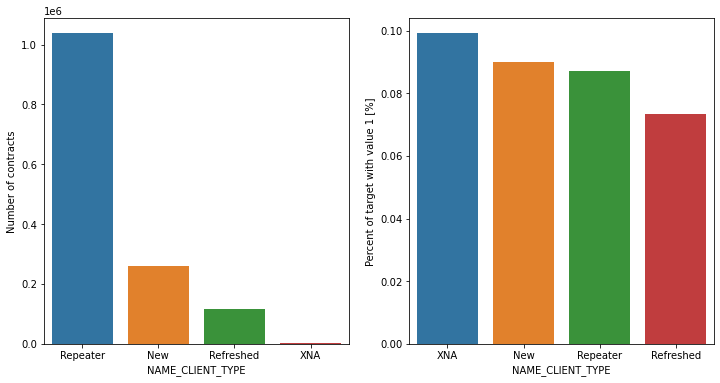

In [47]:
plot_p_stats('NAME_CLIENT_TYPE')

La plupart des demandes précédentes ont le type de client *Répéteur* (~1M), un peu plus de 200K sont *Nouveau* et ~100K sont *Renouvelé*.

En termes de pourcentage de défauts pour les demandes actuelles des clients ayant un historique de demandes antérieures, les clients actuels ayant des demandes antérieures ont des valeurs de pourcentage de défauts allant de 8,5%, 8,25% et 7% correspondant aux types de clients dans le passé *Nouveau*, *Répéteur* et *Renouvelé*, respectivement.

### Chargement des données de bureau balance

In [18]:
bureau_balance = pd.read_csv('C:/Users/lenovo/bureau_balance.csv')

### Fusion de Bureau à bureau_balance

In [19]:
bureau_bureau_balance =bureau.merge(bureau_balance, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='inner')

### Chargement des données de POS_CASH_balance

In [20]:
POS_CASH_balance = pd.read_csv('C:/Users/lenovo/POS_CASH_balance.csv')

### Fusion de Previous application à POS_CASH_balance

In [21]:
POS_CASH_PREV =previous_application.merge(POS_CASH_balance, left_on='SK_ID_PREV', right_on='SK_ID_PREV', how='inner')

### Chargement des données de CREDIT CARD

In [22]:
credit_card = pd.read_csv('C:/Users/lenovo/credit_card_balance.csv')

### Fusion de Previous application à credit_card_balance

In [53]:
credit_card_PREV =previous_application.merge(credit_card, left_on='SK_ID_PREV', right_on='SK_ID_PREV', how='inner')

In [23]:
credit_card.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

### Chrgements de installments_payments

In [25]:
inst_pay = pd.read_csv('C:/Users/lenovo/installments_payments.csv')

In [ ]:
### Fusion de Previous application à installments_payments

In [27]:
inst_pay.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [28]:
inst_pay_PREV =previous_application.merge(inst_pay, left_on='SK_ID_PREV', right_on='SK_ID_PREV', how='inner')

In [29]:
inst_pay_PREV.columns

Index(['SK_ID_PREV', 'SK_ID_CURR_x', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'SK_ID_CURR_y', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMEN

# <a id="3">3.Preprocessing/ Feature Engineering</a>

## <a id="3.2">3.1 Fonctions permettant d'aggregrer les données numériques</a>

In [ ]:

# Use DataFrame.group() Function
result = df.groupby('Courses')['Fee','Discount'].aggregate('sum')
print(result)

In [30]:
def agg_numeric(df, group_var, df_name):
    """Agrégation des variables numériques dans un dataset. Ceci peut
être utilisé pour créer des nouvelles variables pour chaque instance de la variable de regroupement..
    
    Parameters
    --------
        df (dataframe): 
            base dans laquelle sont calculées les statistiques suivant la variable de regroupement
        group_var (string): 
            variable de regroupement
        df_name (string): 
            variable utilisé pour renommer les colonnes
        
    Return
    --------
        agg (dataframe): 
  un dataset avec les statistiques agrégées pour 
toutes les colonnes numériques. Chaque instance de la variable 
de regroupement aura les statistiques (moyenne, nombre, actuellement supportées) calculées.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

## <a id="3.3"> 3.2 Fonction permettant d'aggreger des données catégorielles </a>

In [130]:
def count_categorical(df, group_var, df_name):
    """Calcule les effectifs et les effectifs normalisés pour 
    chaque element de `group_var` de chaque modalité 
    de la variable qualitative
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        Le dataset surlequel s'opère le regroupement
        
    group_var : string
        La variable par laquelle il faut regrouper le dataset. Le dataset final comprendra une ligne
        pour chaque valeur unique de cette variable
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        Un dataset avec les effectifs et effectifs relatifs 
        de chaque modalité de la variable qualitative
        avec une ligne pour id de la variable "group_var".
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the count
    categorical = categorical.groupby(group_var).agg(['count','mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count','count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

## Preprocessing pour la base bureau

### Bureau aggregation

#### Colonnes numériques

In [135]:
bureau_agg_new = agg_numeric(bureau.drop(columns = []), group_var = 'SK_ID_BUREAU', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_BUREAU,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_count,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean
0,5000000,1,-2918.0,1,0.0,1,-2613.0,1,-2639.0,0,...,1,0.00,0,NaN,1,0.0,1,-2512.0,0,NaN
1,5000001,1,-1015.0,1,0.0,1,-831.0,1,-891.0,1,...,1,0.00,1,0.0,1,0.0,1,-891.0,0,NaN
2,5000002,1,-149.0,1,0.0,1,-26.0,1,-26.0,1,...,1,0.00,1,0.0,1,0.0,1,-23.0,0,NaN
3,5000003,1,-135.0,1,0.0,1,230.0,1,-42.0,1,...,1,0.00,1,0.0,1,0.0,1,-42.0,0,NaN
4,5000004,1,-47.0,1,0.0,1,320.0,0,NaN,1,...,1,315127.62,1,0.0,1,0.0,1,-17.0,0,NaN


### Colonnes catégorielles

In [131]:
bureau_agg_cat = count_categorical(bureau, group_var = 'SK_ID_BUREAU', df_name = 'bureau')

In [136]:
bureau_agg_cat.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5000000,1,0.0,1,0.0,1,1.0,1,0.0,1,1.0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
5000001,1,0.0,1,0.0,1,1.0,1,0.0,1,1.0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
5000002,1,0.0,1,0.0,1,1.0,1,0.0,1,1.0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
5000003,1,0.0,1,0.0,1,1.0,1,0.0,1,1.0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
5000004,1,1.0,1,0.0,1,0.0,1,0.0,1,1.0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0


In [137]:
bureau_agg= bureau_agg_new.merge(bureau_agg_cat, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

In [138]:
bureau_agg

,SK_ID_BUREAU,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_count,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,5000000,1,-2918.0,1,0.0,1,-2613.0,1,-2639.0,0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
1,5000001,1,-1015.0,1,0.0,1,-831.0,1,-891.0,1,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
2,5000002,1,-149.0,1,0.0,1,-26.0,1,-26.0,1,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
3,5000003,1,-135.0,1,0.0,1,230.0,1,-42.0,1,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
4,5000004,1,-47.0,1,0.0,1,320.0,0,NaN,1,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,6843453,1,-2385.0,1,0.0,1,-1645.0,0,NaN,0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
1716424,6843454,1,-700.0,1,0.0,1,-335.0,1,-335.0,0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
1716425,6843455,1,-301.0,1,0.0,1,1534.0,0,NaN,0,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
1716426,6843456,1,-1395.0,1,0.0,1,-299.0,1,-1131.0,1,...,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0


### Preprocessing des données de Bureau Balance

In [12]:
bureau_balance = pd.read_csv('C:/Users/lenovo/bureau_balance.csv')

In [13]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


### Aggrégation des colonnes catégorielles

In [82]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Agrégation des colonnes numériques pour l'ensemble de la balance du bureau 

In [83]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean
0,5001709,97,-48.0
1,5001710,83,-41.0
2,5001711,4,-1.5
3,5001712,19,-9.0
4,5001713,22,-10.5


### Fusionner les données numériques et catégorielles aggrégées ensemble pour bureau balance

In [99]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

### Fusionner ces données à celles de bureau pour inclure l'identiiant SK_ID_CURR

In [104]:
bureau_by_loan = bureau_by_loan.merge(bureau_agg, on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean
0,5001709,97,-48.0,0,0.000000,0,0.0,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001710,83,-41.0,5,0.060241,0,0.0,0,0.0,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-329.0,1.0,0.0
2,5001711,4,-1.5,3,0.750000,0,0.0,0,0.0,0,...,1.0,213885.0,0.0,NaN,1.0,0.0,1.0,-30.0,1.0,0.0
3,5001712,19,-9.0,10,0.526316,0,0.0,0,0.0,0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,-261.0,0.0,NaN
4,5001713,22,-10.5,0,0.000000,0,0.0,0,0.0,0,...,1.0,0.0,0.0,NaN,1.0,0.0,1.0,-19.0,0.0,NaN


## Fusionner toutes ces données pour avoir un Final_Train

In [139]:
def merge_train(df):
    train_final = pd.merge(train, df, how='left', on = ['SK_ID_CURR'])
    return train_final

train = merge_train(bureau)

In [121]:
pd.set_option('display.max_columns', 138)
#onehot_encoder(train)

In [122]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.069,0.0833,0.125,0.0369,0.0202,0.0190,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.069,0.0833,0.125,0.0369,0.0202,0.0190,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.

### Exporter le train sous format csv

In [119]:
#test.to_csv('test_app.csv', index=False)
train.to_csv('train_completement.csv', index=False)